
---

<div align=center>
<a href='https://mp.weixin.qq.com/mp/appmsgalbum?__biz=Mzg2OTU4NzI3NQ==&action=getalbum&album_id=1764511202329624577&scene=126#wechat_redirect'> 
<img src=https://github.com/datoujinggzj/WhaleDataAnalysisProject/blob/master/pic/shanghai.png?raw=true width='400' />
</div>

<div align=center>
<img src=https://github.com/datoujinggzj/WhaleDataAnalysisProject/blob/master/pic/ts_forecasting.png?raw=true width='800' />
</div>

👇👇👇点击可跳转！

[第四阶段：时间序列建模预测](#第四阶段：时间序列建模预测)

- [建模方法](#建模方法)
   - 1.1 [Univariate](#Univariate)
   - 1.2 [Multivariate](#Multivariate)

<div class="alert alert-block alert-danger">
<b>注意：</b>

- 需要翻墙才可下载数据和观看油管视频哦！
- 在线看HTML显示不全，请下载到本地操作哦！
- 记得解锁代码再去run哦！
    
</div>

<div class="alert alert-block alert-warning">
<b>【上海新冠疫情数据分析】项目日志</b>

第四阶段：【时间序列建模预测】
    
第二节阶段核心目的：学习并掌握时间序列建模预测，包括单变量和多变量。
    
难度（最高5星）：⭐⭐⭐⭐

Good Luck!
</div>


# 第四阶段：时间序列建模预测

In [1]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from metrics import evaluate

import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
# from bayes_opt import BayesianOptimization
# from gluonts.dataset.common import ListDataset
# from gluonts.evaluation.backtest import make_evaluation_predictions
# from gluonts.model.deepar import DeepAREstimator
# from gluonts.mx.trainer import Trainer
# from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from rich.progress import track

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 18, 8
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

print(tf.__version__)

2.0.0


In [2]:
# IPython
from IPython.display import IFrame

## 时间序列预测

这篇文章带大家来介绍，时间序列预测的常用方法，建模本身就是个比较玄学的东西，能用的模型太多了，我们其实就是在反复的实验，寻找最优。

那么单变量和多变量预测的最大区别就是：**我们是否有其他的regressors，而非仅仅是时序数据本身。**

时间序列数据：

- time_series_covid19_confirmed_US.csv
- time_series_covid19_confirmed_global.csv
- time_series_covid19_deaths_US.csv
- time_series_covid19_deaths_global.csv
- time_series_covid19_recovered_global.csv

横截面数据：

- csse_covid_19_daily_reports
- csse_covid_19_daily_reports_us

正在读取【横截面】数据......
读取完毕
正在读取【时间序列】数据......
读取完毕
正在获取并处理【上海】数据（数据来自上海卫健委）......
读取完毕


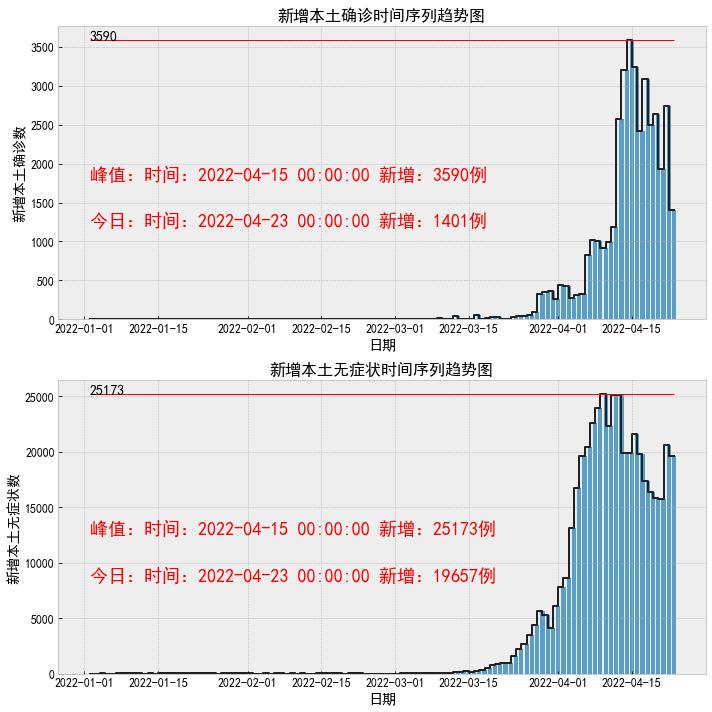

In [3]:
from getdata import GET_csse_covid_19_daily_reports,GET_csse_covid_19_time_series,GET_shanghai_data

# get data
latest_data_global,prev_data_global,latest_data_us,prev_data_us = GET_csse_covid_19_daily_reports()
ts_confirmed_us,ts_confirmed_global,ts_deaths_us,ts_deaths_global,ts_recovered_global = GET_csse_covid_19_time_series()
ts_shanghai_covid = GET_shanghai_data(data_name = 'ts_shanghai_covid', plot=True)  # 这里包含近10天的上海无症状新增趋势！

In [4]:
from data_processing import ts_process_CHINA,ts_process_US,daily_process

In [5]:
ts_confirmed_CHINA_incre, loc_data_CHINA, sorted_provinces = ts_process_CHINA(ts_confirmed_global,clip=False)
ts_deaths_CHINA_incre, _, _ = ts_process_CHINA(ts_deaths_global,clip=False)
ts_recovered_CHINA_incre, _, _ = ts_process_CHINA(ts_recovered_global,clip=False)

In [6]:
ts_confirmed_US_incre,loc_data_us,sorted_state = ts_process_US(ts_confirmed_us,clip=False)
ts_deaths_US_incre,_,_,population = ts_process_US(ts_deaths_us,death = True,clip=False)

In [7]:
latest_data_CHINA = daily_process(latest_data_global, country = 'China')
prev_data_CHINA = daily_process(prev_data_global, country = 'China')
latest_data_US = daily_process(latest_data_us, country = 'US')
prev_data_US = daily_process(prev_data_us, country = 'US')

In [8]:
start_missing_day = '2022-04-08'
data_to_change = ts_confirmed_CHINA_incre['Shanghai'][ts_confirmed_CHINA_incre['Shanghai'].index>=start_missing_day]
ts_confirmed_CHINA_incre['Shanghai'][ts_confirmed_CHINA_incre['Shanghai'].index>=start_missing_day] = ts_shanghai_covid['新增本土确诊'][ts_shanghai_covid.index>=start_missing_day][data_to_change.index]

<div align=center>
<img src=https://github.com/datoujinggzj/WhaleDataScienceProject/blob/master/pic/sep.gif?raw=true width='800' />
</div>

- 数据处理和准备

要注意，我们不能随机split训练集和测试集，因为每个样本之间并不是独立的，不能使用

```python
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
```

In [9]:
split_date = '2022-01-01'
df_train = ts_confirmed_US_incre.loc[ts_confirmed_US_incre.index < split_date]
df_test = ts_confirmed_US_incre.loc[ts_confirmed_US_incre.index >= split_date]
print(f"{len(df_train)} days of training data \n {len(df_test)} days of testing data ")

710 days of training data 
 113 days of testing data 


In [10]:
resultsDict = {}
predictionsDict = {}

评估指标

- [R-Squared](https://www.investopedia.com/terms/r/r-squared.asp)
- [Mean Absolute Error(MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error)
- [Mean Absolute Percentage Error(MAPE)](https://www.statisticshowto.com/mean-absolute-percentage-error-mape/)
- [Mean Squared Error(MSE)](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/mean-squared-error/)
- [Root Mean Squared Error(RMSE)](https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/)
- [Normalized Root Mean Squared Error(NRMSE)](https://stats.stackexchange.com/questions/255276/normalized-root-mean-square-error-nrmse-with-zero-mean-of-observed-value)
- [Weighted Absolute Percentage Error(WAPE)](https://stackoverflow.com/questions/68529201/how-to-calculate-wape-for-given-dataframe-in-python)
- [Weighted Mean Absolute Percentage Error(WMAPE)](https://www.baeldung.com/cs/mape-vs-wape-vs-wmape)

这里我们计算这四个指标来作为代表：

 metrics=("mae", "rmse", "mape", "r2")

In [11]:
mean = df_train['New York'].mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test['New York'], mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(
    df_test['New York'], df_test['New York'].shift(1).fillna(0))
predictionsDict['Yesterdays value'] = df_test['New York'].shift(1).fillna(0).values

### Univariate Forecasting

- [Simple Exponential Smoothing (SES)](https://koalatea.io/python-ses-timeseries/)
- [Holt Winter’s Exponential Smoothing (HWES)](https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873)
- [Autoregression (AR)](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)
- [Moving Average (MA)](https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/)
- [Autoregressive Moving Average (ARMA)](https://www.math.pku.edu.cn/teachers/lidf/course/fts/ftsnotes/html/_ftsnotes/fts-arma.html)
- [Autoregressive integrated moving average (ARIMA)](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
- [Prophet](https://facebook.github.io/prophet/docs/quick_start.html)


#### Simple Exponential Smoothing (SES)

In [12]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = SimpleExpSmoothing(temp_train['New York'])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_SES = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test['New York'], yhat_SES.values)
predictionsDict['SES'] = yhat_SES.values

Output()

#### Holt Winter’s Exponential Smoothing (HWES)

In [13]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ExponentialSmoothing(temp_train['New York'])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_HWES = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test['New York'], yhat_HWES.values)
predictionsDict['HWES'] = yhat_HWES.values

Output()

#### Autoregression (AR)

In [14]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = AR(temp_train['New York'])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_AR = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test['New York'], yhat_AR.values)
predictionsDict['AR'] = yhat_AR.values

Output()

#### Moving Average (MA)

In [15]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ARMA(temp_train['New York'],order=(0, 1))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_MA = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test['New York'], yhat_MA.values)
predictionsDict['MA'] = yhat_MA.values

Output()

#### Autoregressive Moving Average (ARMA)

In [16]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ARMA(temp_train['New York'].diff().fillna(0),order=(1, 1))
    model_fit = model.fit(transparams=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_ARMA = pd.concat(yhat)
resultsDict['ARMA'] = evaluate(df_test['New York'], yhat_ARMA.values)
predictionsDict['ARMA'] = yhat_ARMA.values

Output()

#### Autoregressive integrated moving average (ARIMA)

In [17]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ARIMA(temp_train['New York'],order=(1,0,0))
    model_fit = model.fit(transparams=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_ARIMA = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test['New York'], yhat_ARIMA.values)
predictionsDict['ARIMA'] = yhat_ARIMA.values

Output()

#### Auto ARIMA

In [18]:
autoModel = pm.auto_arima(df_train['New York'], trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=True)
# autoModel.plot_diagnostics(figsize=(14,10))
# plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=13347.733, Time=0.73 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=14640.016, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=14145.272, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=13346.430, Time=0.68 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=13363.877, Time=0.32 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=13562.254, Time=0.54 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=13364.415, Time=0.97 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=13346.874, Time=1.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=13433.366, Time=0.44 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=13332.877, Time=1.11 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=13340.164, Time=0.67 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=13337.682, Time=1.58 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=inf, Time=1.29 sec
 ARIMA(3,2,2)(0,0,0)[0]        

In [19]:
best_order = autoModel.order
model0 = ARIMA(df_train['New York'],order = best_order)
model_fit0 =model0.fit(disp=False)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ARIMA(temp_train['New York'],order = best_order)
    model_fit = model.fit(disp=False,transparams=False,start_params = model_fit0.params)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),dynamic=False)
    yhat = yhat + [predictions]
yhat_autoarima = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(best_order)] = evaluate(
    df_test['New York'], yhat_autoarima)
predictionsDict['AutoARIMA {0}'.format(best_order)] = yhat_autoarima.values

Output()

#### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [20]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = SARIMAX(temp_train['New York'],order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False,transparams=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),dynamic=False)
    yhat = yhat + [predictions]
    
yhat_SARIMAX = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test['New York'], yhat_SARIMAX.values)
predictionsDict['SARIMAX'] = yhat_SARIMAX.values

Output()

#### Auto - SARIMA

In [21]:
# building the model
autoModel = pm.auto_arima(df_train['New York'], trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
# autoModel.plot_diagnostics(figsize=(14,10))
# plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[6]             : AIC=13313.882, Time=2.65 sec
 ARIMA(0,2,0)(0,0,0)[6]             : AIC=14640.016, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[6]             : AIC=14146.943, Time=0.15 sec
 ARIMA(0,2,1)(0,0,1)[6]             : AIC=inf, Time=0.74 sec
 ARIMA(2,2,2)(0,0,1)[6]             : AIC=13327.855, Time=2.13 sec
 ARIMA(2,2,2)(1,0,0)[6]             : AIC=13366.697, Time=0.76 sec
 ARIMA(2,2,2)(2,0,1)[6]             : AIC=13316.831, Time=3.56 sec
 ARIMA(2,2,2)(1,0,2)[6]             : AIC=13319.056, Time=4.31 sec
 ARIMA(2,2,2)(0,0,0)[6]             : AIC=13347.733, Time=0.71 sec
 ARIMA(2,2,2)(0,0,2)[6]             : AIC=13316.638, Time=3.08 sec
 ARIMA(2,2,2)(2,0,0)[6]             : AIC=13363.630, Time=1.51 sec
 ARIMA(2,2,2)(2,0,2)[6]             : AIC=13356.183, Time=4.62 sec
 ARIMA(1,2,2)(1,0,1)[6]             : AIC=inf, Time=2.49 sec
 ARIMA(2,2,1)(1,0,1)[6]             : AIC=13411.952, Time=1.88 sec
 ARIMA(3,2,2)(1,0,1)[6]        

In [22]:
best_order = autoModel.order
seasonalOrder = autoModel.seasonal_order
# model0 = ARIMA(df_train['New York'],order = best_order)
# model_fit0 =model0.fit(disp=False)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = SARIMAX(temp_train['New York'],
                    order = best_order,
                   seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False,transparams=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),dynamic=False)
    yhat = yhat + [predictions]
yhat_AutoSARIMAX = pd.concat(yhat)
resultsDict['AutoSARIMAX  {0}'.format(best_order,seasonalOrder)] = evaluate(
    df_test['New York'], yhat_AutoSARIMAX)
predictionsDict['AutoSARIMAX  {0}'.format(best_order,seasonalOrder)] = yhat_AutoSARIMAX.values

Output()

In [23]:
yhat_dict = {
    'SES':yhat_SES,
    'HWES':yhat_HWES,
    'AR':yhat_AR,
    'MA':yhat_MA,
    'ARMA':yhat_ARMA,
    'ARIMA':yhat_ARIMA,
    'AUTOARIMA':yhat_autoarima,
    'SARIMAX':yhat_SARIMAX,
    'AUTOSARIMAX':yhat_AutoSARIMAX
}

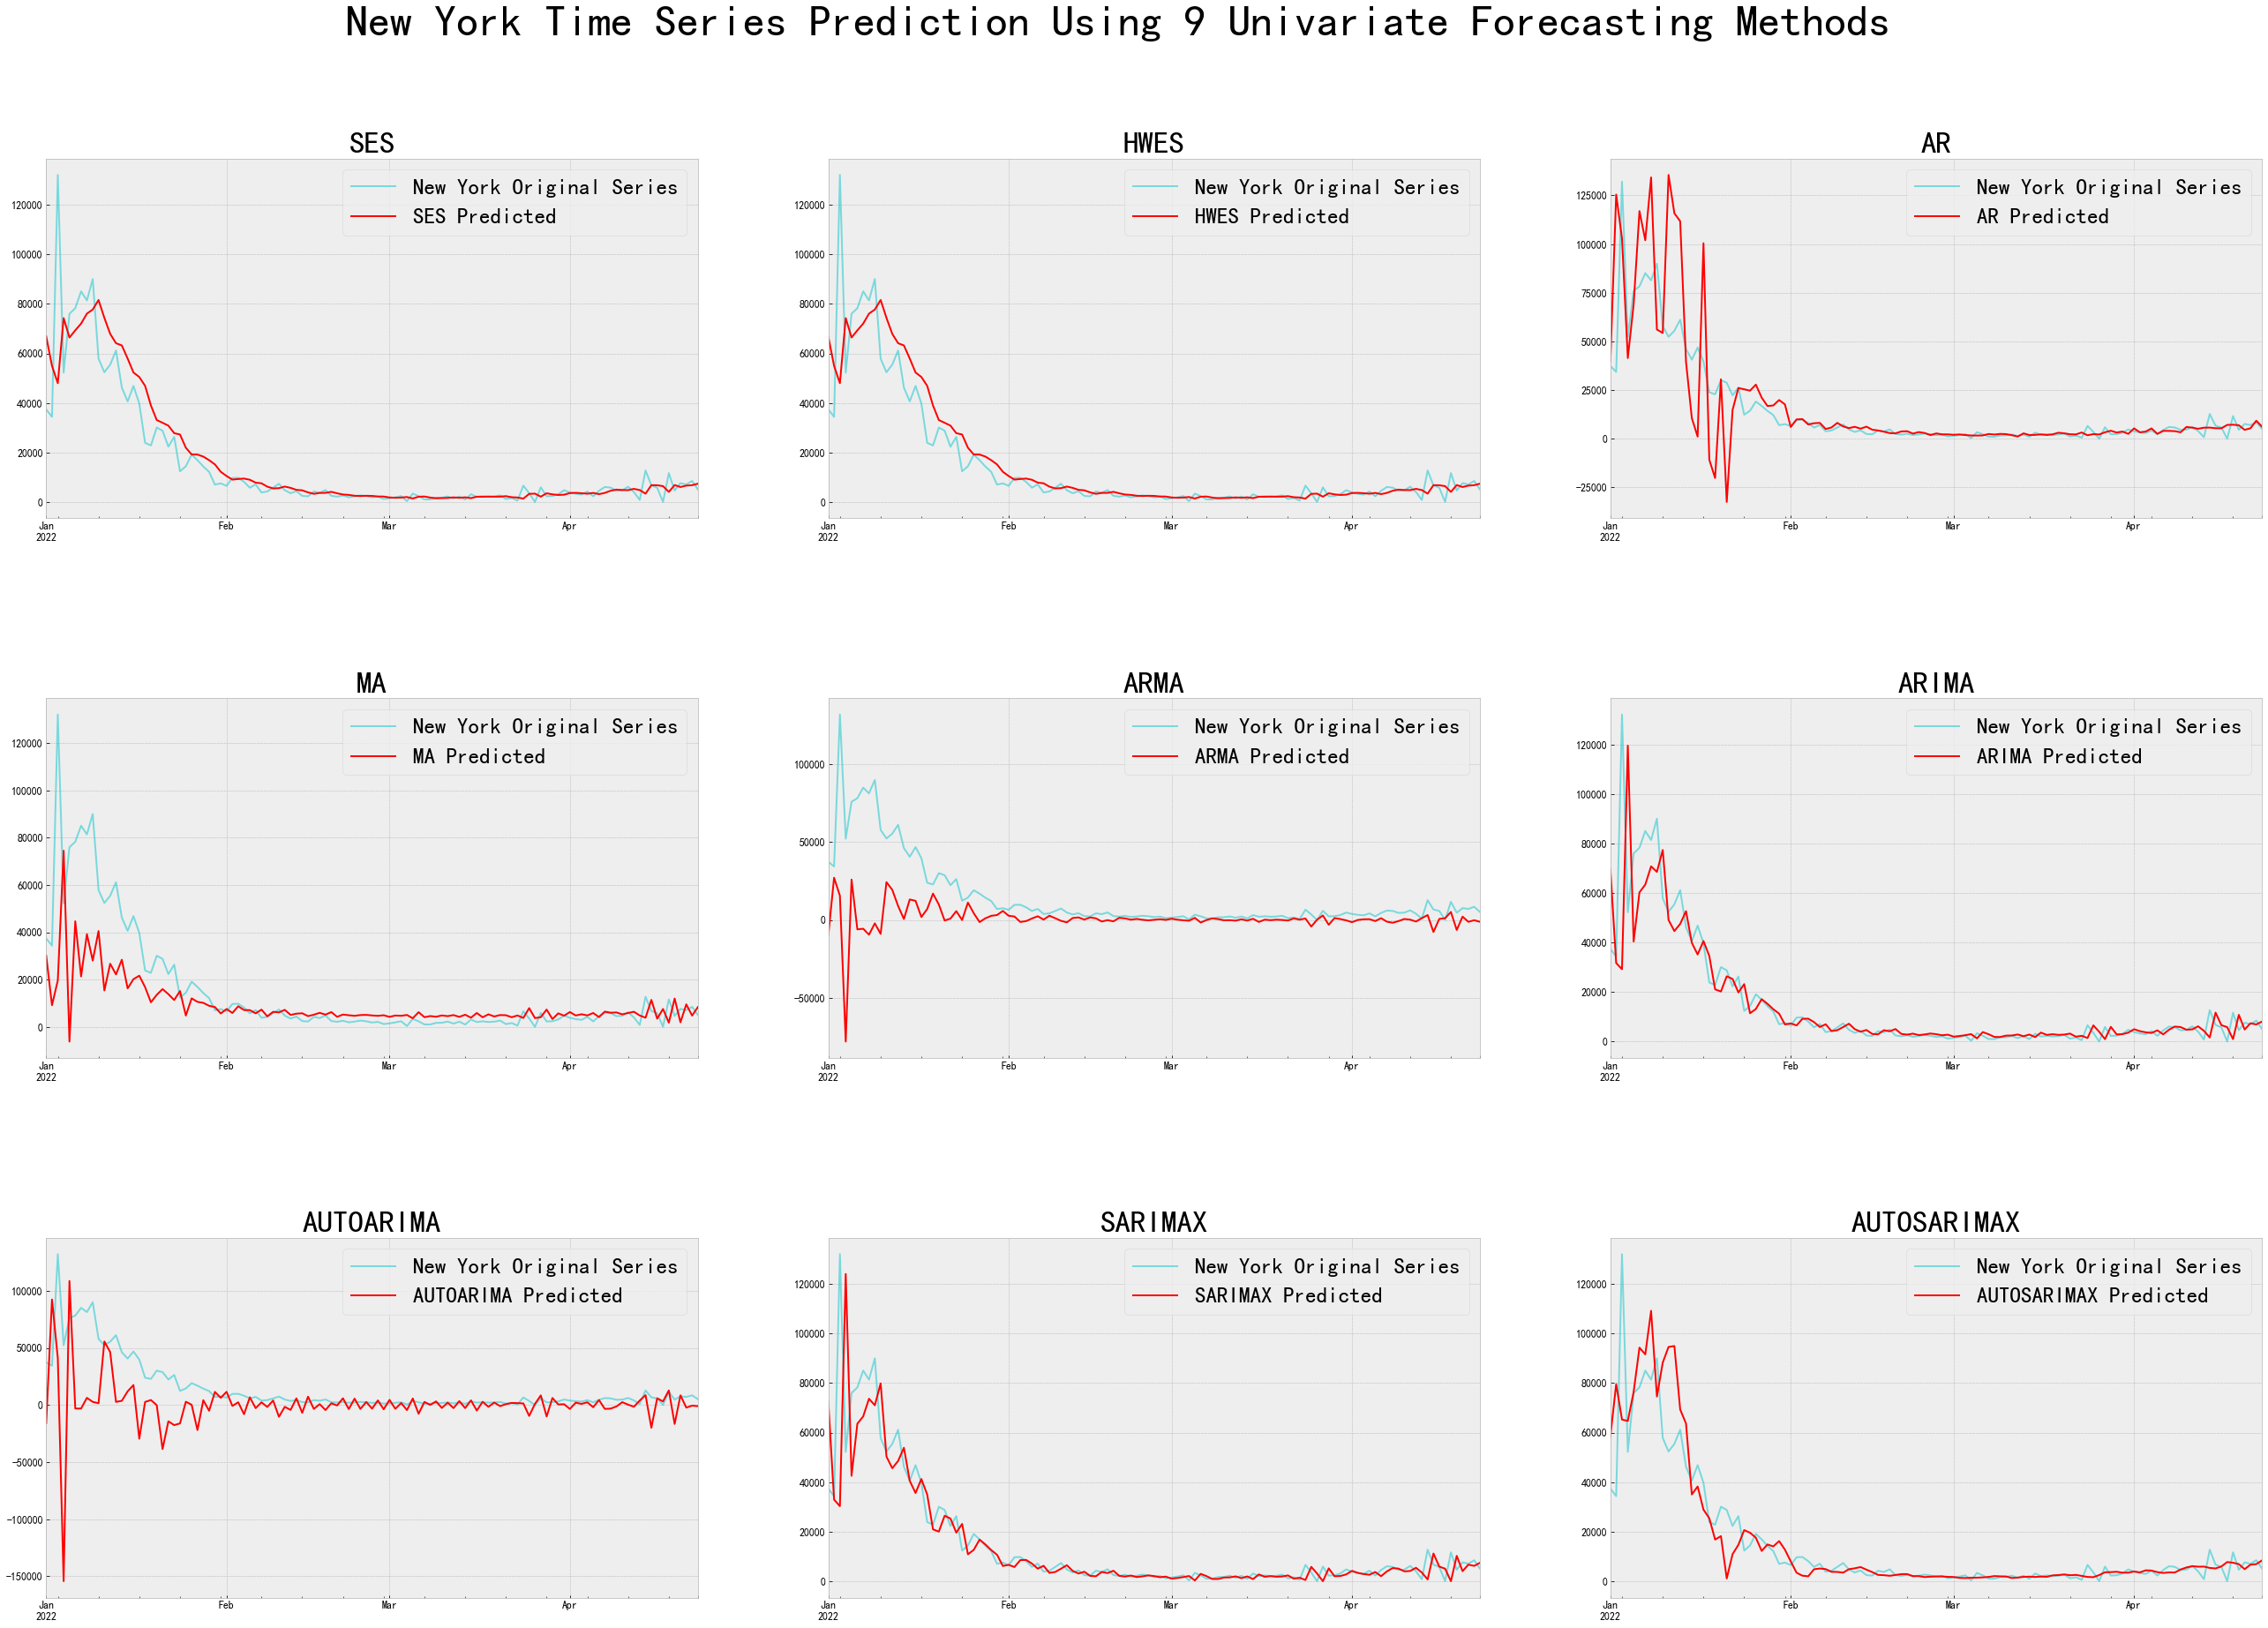

In [24]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(3*15, 10*3))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("New York Time Series Prediction Using 9 Univariate Forecasting Methods", fontsize=50, y = .96)
for yhat_key,ax in zip(yhat_dict.keys(), axs.ravel()):
    df_test['New York'].plot(ax=ax,alpha = .5, label = "New York Original Series", color = '#06c3cc')
    yhat_dict[yhat_key].plot(ax=ax,color = 'red',label=f'{yhat_key} Predicted')
    ax.set_title(f"{yhat_key.upper()}",fontsize = 35)
    ax.legend(fontsize = 25)
    ax.set_xlabel("")
plt.show()

### Multivariate time series forecasting

说白了univariate就是一个变量随时间变化，这个就是多个变量随时间变化，那么怎么变成多变量呢？

你可以根据时间进行特征工程，细拆！

<div class="alert alert-block alert-success"><b>Step 1</b>: 
    
1. 完善下面代码，把时间进行提取拆分
    
</div>

In [25]:
df_train

,New York,Puerto Rico,New Jersey,Texas,Pennsylvania,Oklahoma,Iowa,Kentucky,District of Columbia,Tennessee,...,Kansas,Louisiana,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Alaska,Wyoming
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,36728,1362,9732,17331,11079,3380,4042,9938,9200,6335,...,6554,12164,5784,13746,35376,4137,7058,5802,883,382
2021-12-28,47102,1716,15234,14795,13943,2443,2473,4253,1868,11440,...,35,4313,7280,10315,0,9864,2698,4661,0,293
2021-12-29,62201,8203,26473,14286,16730,765,2562,5513,1412,12688,...,7348,9378,11910,16109,29129,5210,3594,8500,992,325
2021-12-30,71787,14331,35175,15600,19127,4166,2469,0,2241,14632,...,72,12467,15446,22036,0,6777,4885,8020,0,396


In [26]:
def gen_time_feat(df, target=None):
    df['date'] = 
    df['hour'] = 
    df['dayofweek'] = 
    df['quarter'] = 
    df['month'] = 
    df['year'] = 
    df['dayofyear'] = 
    df['sin_day'] = 
    df['cos_day'] =
    df['dayofmonth'] = 
    df['weekofyear'] = 
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [27]:
X_train_df, y_train = gen_time_feat(df_train, target='New York')
X_test_df, y_test = gen_time_feat(df_test, target='New York')

In [28]:
scaler = StandardScaler()

# 对train test进行标准化
"你的代码"

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

#### Linear models

##### Bayesian regression

BayesianRidge estimates a probabilistic model of the regression problem as described above. The prior for the coefficient  is given by a spherical Gaussian:
$$
p(w|\lambda) =
\mathcal{N}(w|0,\lambda^{-1}\mathbf{I}_{p})
$$

The priors over  and  are chosen to be gamma distributions, the conjugate prior for the precision of the Gaussian. The resulting model is called Bayesian Ridge Regression, and is similar to the classical Ridge.

<div class="alert alert-block alert-success"><b>Step 2</b>: 
    
告诉我下面3个regression方法的特点，和linear regression的区别，如何避免过拟合？
    
</div>

In [29]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat_BayesianRidge = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test['New York'], yhat_BayesianRidge)
predictionsDict['BayesianRidge'] = yhat_BayesianRidge

##### LARS Lasso

LassoLars is a lasso model implemented using the LARS algorithm, and unlike the implementation based on coordinate descent, this yields the exact solution, which is piecewise linear as a function of the norm of its coefficients.

In [30]:
reg = linear_model.LassoLars(alpha=0.1)
reg.fit(X_train, y_train)
yhat_LassoLars = reg.predict(X_test)
resultsDict['LassoLars'] = evaluate(df_test['New York'], yhat_LassoLars)
predictionsDict['LassoLars'] = yhat_LassoLars

##### Automatic Relevance Determination Regression (ARD)¶

In [31]:
reg = linear_model.ARDRegression(compute_score=True)
reg.fit(X_train, y_train)
yhat_ARDRegression = reg.predict(X_test)
resultsDict['ARDRegression'] = evaluate(df_test['New York'], yhat_ARDRegression)
predictionsDict['ARDRegression'] = yhat_ARDRegression

#### Tree models

<div class="alert alert-block alert-success"><b>Step 3</b>: 
    
1. 什么是bagging和boosting
2. GBDT的原理叙述
3. XGB和GBDT的关系
4. LightGBM是啥和前面的有啥关系
5. 树形算法的优缺点简述
    
</div>

##### Decision Tree

In [32]:
from sklearn.tree import DecisionTreeRegressor

In [33]:
reg = DecisionTreeRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat_DecisionTree = reg.predict(X_test)
resultsDict['DecisionTree'] = evaluate(df_test['New York'], yhat_DecisionTree)
predictionsDict['DecisionTree'] = yhat_DecisionTree

##### Randomforest

In [34]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat_RandomForest = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test['New York'],yhat_RandomForest)
predictionsDict['Randomforest'] = yhat_RandomForest

##### Adaboost

In [35]:
from sklearn.ensemble import AdaBoostRegressor

In [36]:
reg = AdaBoostRegressor(random_state=0, n_estimators=100)
reg.fit(X_train, y_train)
yhat_AdaBoost = reg.predict(X_test)
resultsDict['AdaBoost'] = evaluate(df_test['New York'],yhat_AdaBoost)
predictionsDict['AdaBoost'] = yhat_AdaBoost

##### XGBoost

In [37]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat_XGBoost = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test['New York'], yhat_XGBoost)
predictionsDict['XGBoost'] = yhat_XGBoost

##### Lightgbm

In [38]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat_lightGBM = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test['New York'], yhat_lightGBM)
predictionsDict['Lightgbm'] = yhat_lightGBM

#### Support Vector Regressor

<div class="alert alert-block alert-success"><b>Step 4</b>: 
    
1. 什么是支持向量
2. SVM适合什么样的数据
3. 怎么理解高斯核函数
    
</div>

In [39]:
reg = svm.SVR()
reg.fit(X_train, y_train)
yhat_SVR = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test['New York'], yhat_SVR)
predictionsDict['SVM RBF'] = yhat_SVR

#### Nearest neighbors

In [40]:
reg = KNeighborsRegressor(n_neighbors=3)
reg.fit(X_train, y_train)
yhat_KNN = reg.predict(X_test)
resultsDict['KNN'] = evaluate(df_test['New York'], yhat_KNN)
predictionsDict['KNN'] = yhat_KNN

#### Deep Learning

In [ ]:
"完善下面代码"

In [41]:
#对于我们的深度学习模型，将创建一个数据窗口，对于每个时间 T，我们将把从 T-7 到 T 的数据加到目标 Y(t) 的 X中
BATCH_SIZE = 32
BUFFER_SIZE = 64
WINDOW_LENGTH = 12


def window_data(X, Y, window=7):
    '''
    数据集长度将减少以保证所有样本都有窗口，因此新长度将为 len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        '你的代码'
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = '你的代码'
y_w = '你的代码'

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [42]:
dropout = 0.0
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='rmsprop', loss='mae')

In [43]:
EVALUATION_INTERVAL = 200
EPOCHS = 20

model_history = lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  # ,call

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 6s 31ms/step - loss: 3204.1480 - val_loss: 11306.8764
Epoch 2/20
200/200 [==============================] - 3s 16ms/step - loss: 1709.7838 - val_loss: 10612.2126
Epoch 3/20
200/200 [==============================] - 3s 16ms/step - loss: 1438.0138 - val_loss: 9077.6540
Epoch 4/20
200/200 [==============================] - 3s 17ms/step - loss: 1316.5482 - val_loss: 8778.4214
Epoch 5/20
200/200 [==============================] - 3s 16ms/step - loss: 1280.4897 - val_loss: 8074.3331
Epoch 6/20
200/200 [==============================] - 3s 16ms/step - loss: 1186.4400 - val_loss: 7727.8092
Epoch 7/20
200/200 [==============================] - 3s 16ms/step - loss: 1113.5329 - val_loss: 7060.2739
Epoch 8/20
200/200 [==============================] - 3s 17ms/step - loss: 1083.6595 - val_loss: 6456.5271
Epoch 9/20
200/200 [==============================] - 3s 17ms/step - loss: 1049.8410 - val_loss: 73

In [44]:
yhat_LSTM = lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test, yhat_LSTM)
predictionsDict['Tensorflow simple LSTM'] = yhat_LSTM

保存结果

In [45]:
with open('scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
result_df = '你的代码'
result_df

,mae,rmse,mape,r2
Naive mean,12100.090490,25061.990568,8.675757e+11,-0.171814
Yesterdays value,4953.734513,13558.736582,8.233628e+11,0.657022
SES,4724.025576,10724.455429,8.633496e+11,0.785425
HWES,4724.025576,10724.455429,8.633496e+11,0.785425
AR,8407.739339,19448.537633,8.243584e+11,0.294330
MA,8757.279544,18672.747056,9.969011e+11,0.349505
ARMA,13627.563814,27839.187800,1.103581e+11,-0.445909
ARIMA,5185.765565,13534.852385,8.673517e+11,0.658229
"AutoARIMA (2, 2, 3)",16162.704981,32259.598317,3.576454e+11,-0.941537
SARIMAX,5051.966837,13589.460089,7.234183e+11,0.655466


来看一下下面四个metric之间的比较！

In [ ]:
"完善代码"

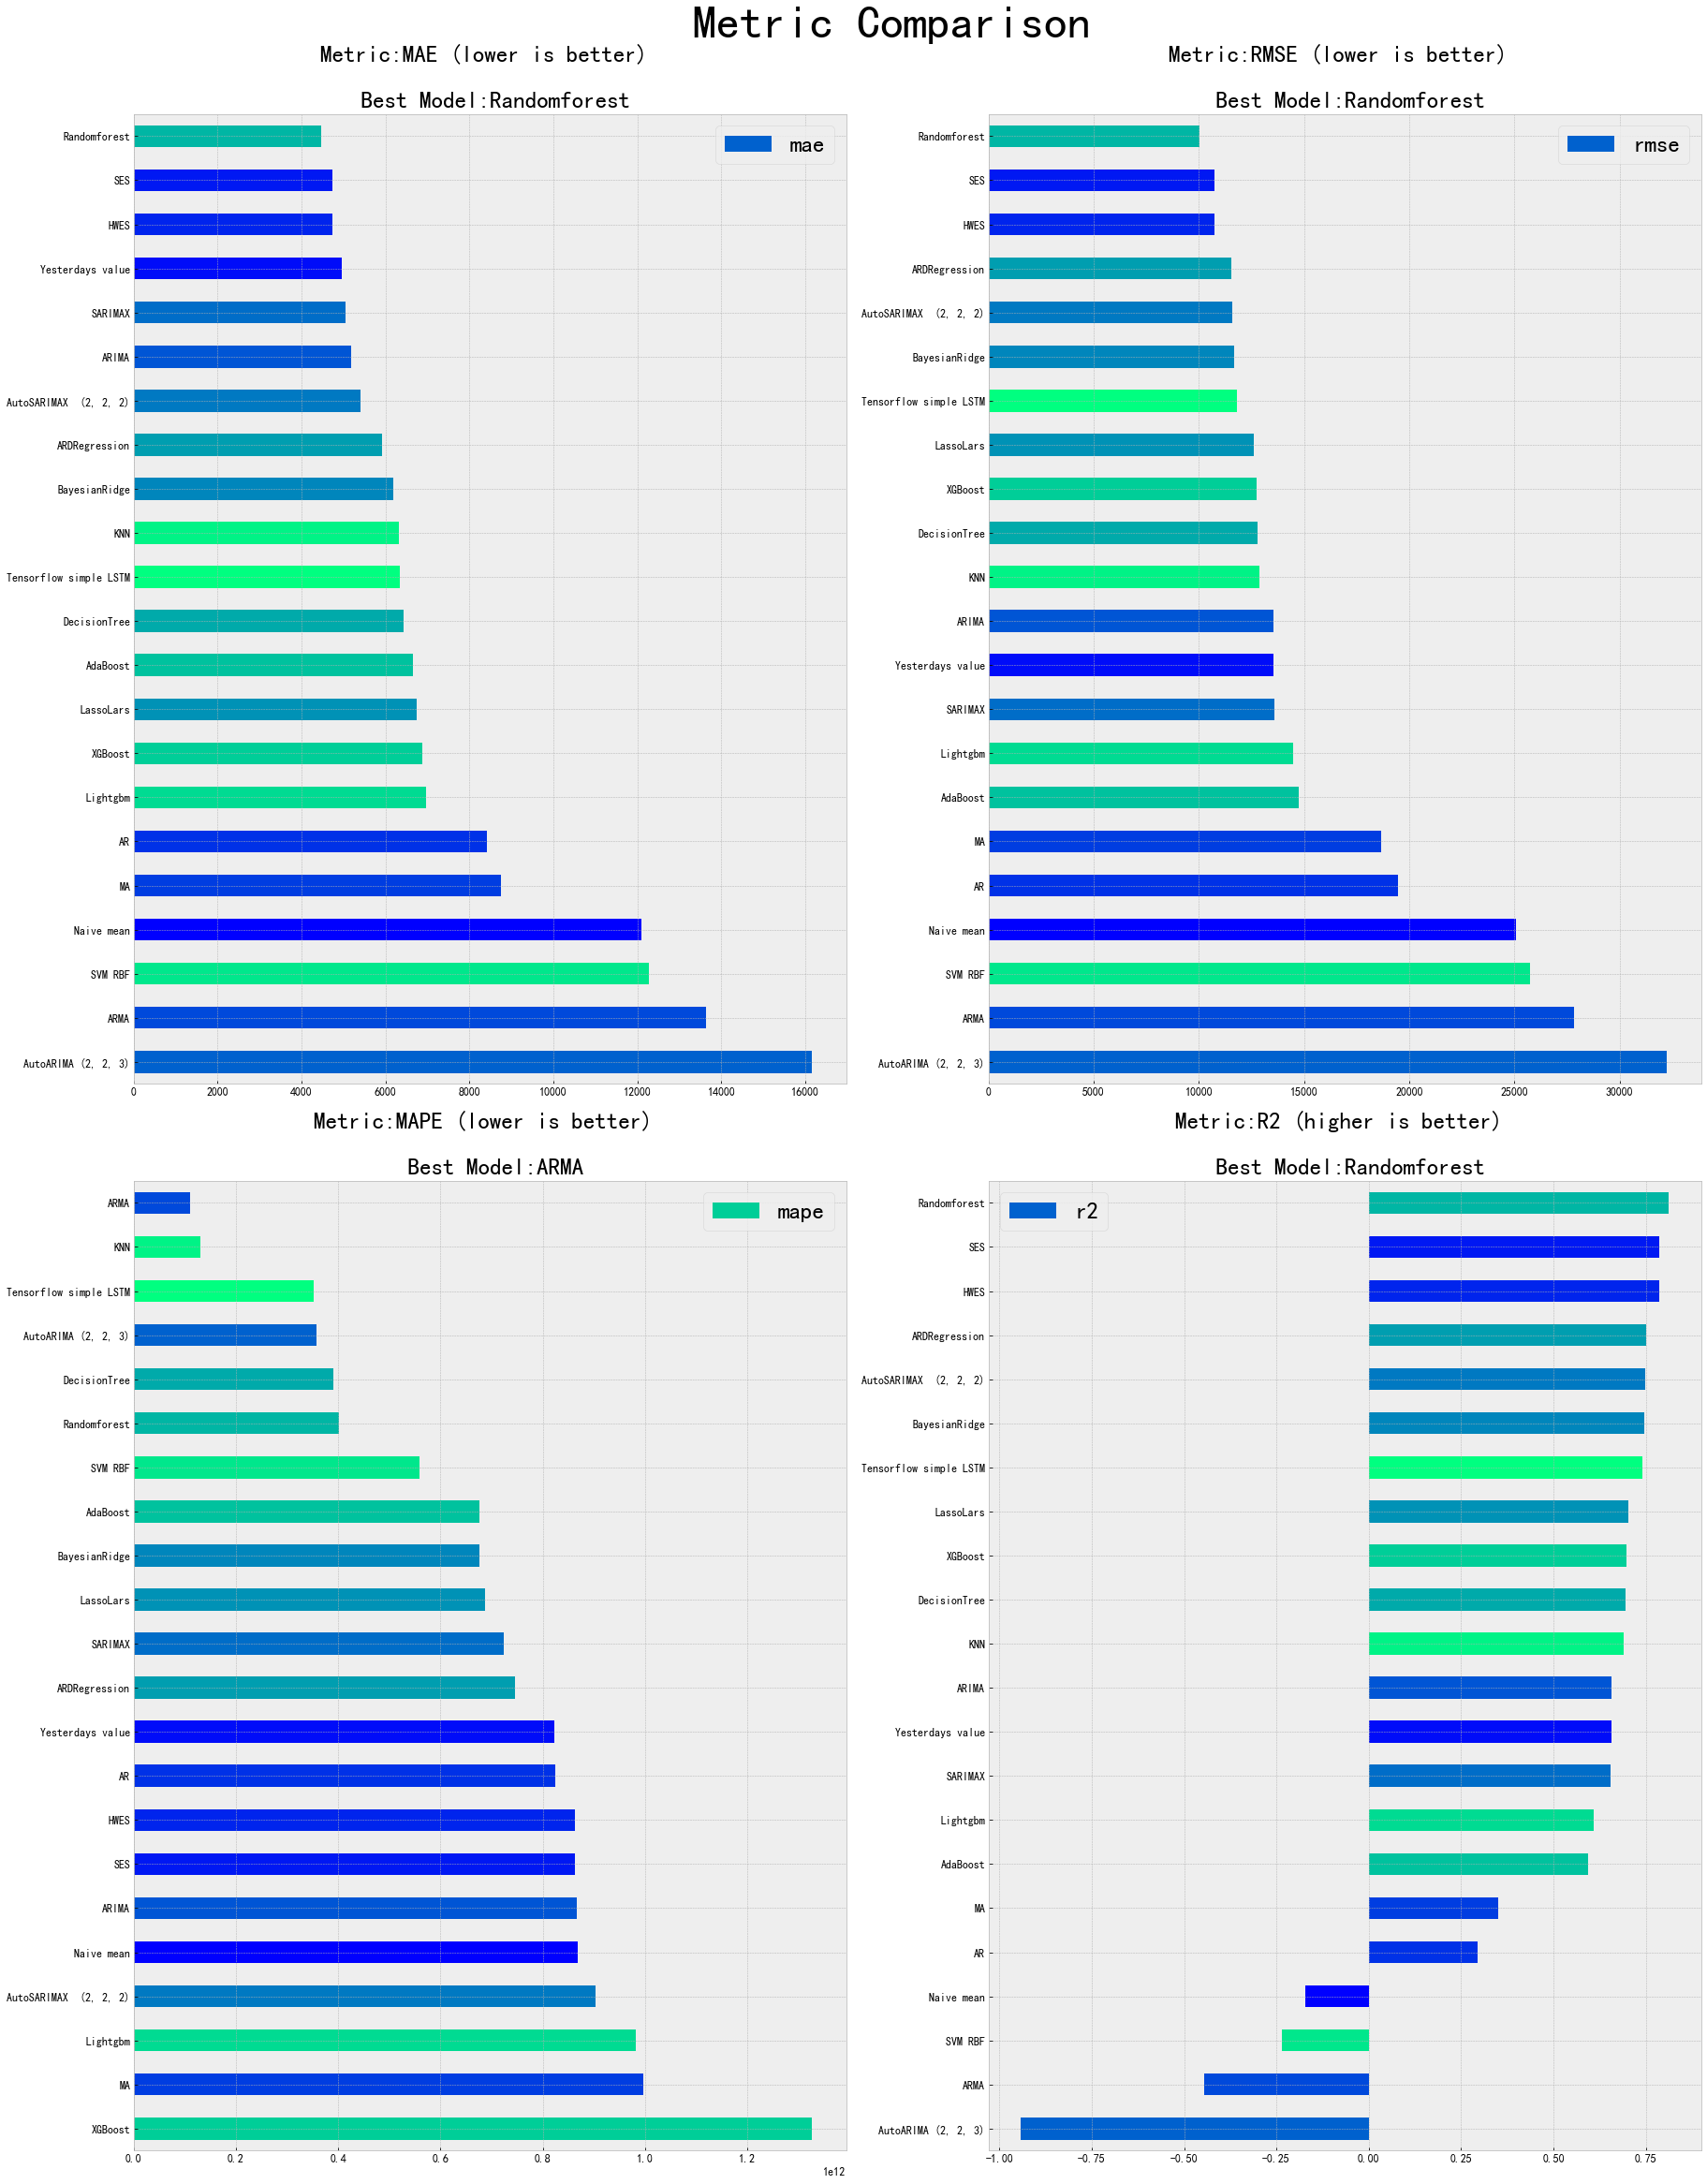

<Figure size 1296x576 with 0 Axes>

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2*15, 20*2))
plt.subplots_adjust(hspace=0.1)
plt.suptitle("Metric Comparison", fontsize=50, y = .92)

idx = result_df.index
cols = result_df.columns
pallette = "使用cmap等于winter"
colors = [pallette(x) for x in range(len(idx))]
color_dict = dict(zip(idx, colors))
for metric,ax in zip(result_df.columns, axs.ravel()):
    
    # 如果metric不是r2，结果按从大到小排列
    if metric != 'r2':
        df = result_df[metric].sort_values(ascending=False)
        df.plot(
            ax=ax,
            kind = 'barh',
            colormap="Paired",
            color=[color_dict.get(x, "#ff7f00") for x in df.index],
            label = metric
        )
        ax.set_title(f"Metric:{metric.upper()} (lower is better) \n\n Best Model:{df.index[-1]}",fontsize = 25)

    else:
        df = '排序'
        df.plot(
            ax=ax,
            kind = 'barh',
            colormap="Paired",
            color=[color_dict.get(x, "#ff7f00") for x in df.index],
            label = metric
        )
        ax.set_title(f"Metric:{metric.upper()} (higher is better) \n\n Best Model:{df.index[-1]}",fontsize = 25)
        
    ax.legend(fontsize = 25)
    ax.set_xlabel("")
plt.show()
plt.tight_layout()